# Example Jupyter Notebook/Template - Deepl Learning for dynamical systems

## 1. Dynamical Systems Introduction

Dynamical systems is a general term used to define a physical system evolving over another quantity, typically, time.  This is usually done by employing the use of differential equations that govern the dynamics of the system by applying some known constraints (physical laws).

However, systems with increasing complexity are significantly more challenging to define using differential equations.  To describe these systems in a more computationally efficient manner, Data-driven modeling is an approach that has garnered great interest over recent years.

In this notebook, we are going to explore some such approaches applied to a system of a simple cantilever beam.


## 2. Non Linear Euler-Bernoulli Beam Model
The NLEBB model is a mechanical model that describes large deformations of beams that are subject to both, axial and transverse loading. The beam itself is based on the Euler-Bernoulli beam theory, which assumes that even in the deformed state, a cross-section of the beam at any point along the length of the beam remains plain and orthogonal to the center line, i.e., there is no shear.

In the problem below, we shall discuss the dynamic behavior of a 2-dimensional beam.  The beam is a simple cantilever of length $L$ is observed in the ${xz}$ plane under a load $q(x)$.

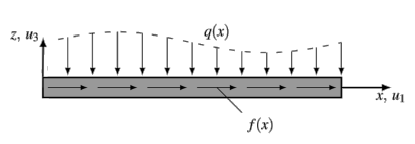

### 2.1 Mathematical Representation
The 2D deformation ($u_1, u_3$), is expressed through the center-line ($u, w$) as: <br>
$ u_1(x,z) = u(x) - z w'(x)$
<br>
$ u_3(x,z) = w(x)$

where x is the distance of any point from the fixed end of the beam

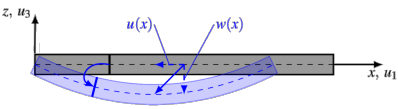 <br>
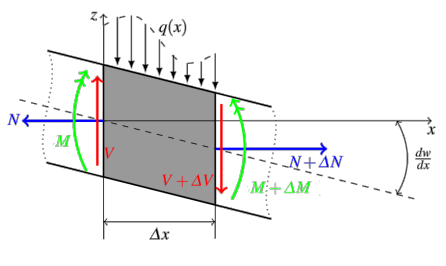

The Von Karman strain can now be defined as:
$\epsilon_{11}(x,z) = u'(x) - \frac{1}{2} w'(x)^2 - zw''(x)$

Axial Strain is given by 
$\epsilon(x) = u' + \frac{1}{2} w'^2$

and curvature strain is given by
$\kappa(x) = -w''$

To obtain the forces in the centreline, we use $N(x) = E A \epsilon$
Similarly, for moment, we use $M(x) = E I \kappa$

The equilibrium equations can now be written as: <br>
$f(x) = \rho A \ddot{u} - N'$
<br>
$q(x) = \rho A \ddot(w) - (Nw')' - M''$

The boundary conditions for $\hat{x} \epsilon \{0, L\}$ are hence defined as:
- Dirichlet: <br> $u(\hat{x}) = 0$ <br> $w(\hat{x}) = 0$ <br> $w'(\hat{x}) = 0$
- Neumann:   <br> $N(\hat{x}) = \hat{N}$ <br> $M(\hat{x}) = \hat{M}$ <br> $M' + Nw'|_{\hat{x}} = \hat{Q}$ <br>
- for initial conditions (at $t = t_0$) <br> $u(t_0) = u_0$ <br> $\dot{u}(t_0) = v_0$ <br> $w(t_0) = w_0$ <br> $\dot{w}(t_0) = \omega_0$

This gives us our initial boundary value problem.

.
.
.
.
.
*Rest of the method to be added*

The implementation of the same can be seen in the MATLAB code below 


In [2]:
%%writefile nlebb_dynamic.m
% -------------------------------------------------------------------------
% Physics-aware machine learning
% Cyber-Physical Simulation, TU Darmstadt
% -------------------------------------------------------------------------
% Nonlinear Euler-Bernoulli beam 
% Dynamic deformation example with implicit Newmark time integration
% -------------------------------------------------------------------------

clear all;

% -------------------------------------------------------------------------
% --- INPUTS

% Geometric and material parameters
L = 0.2;            % Length [m]
W = 0.02;           % Width [m]
H = 0.02;           % Height [m]
E = 50e6;           % Young's modulus [Pa]
rho = 1100;         % Density [kg/m³]          

% Cross-section parameters (assuming rectangular cross-section)
EA = E * W*H;       % E*A
EI = E * H^3*W/12;  % E*I
RA = rho * W*H;     % rho*A
param = [EA, EI, RA];

% Dirichlet boundary conditions (0:free, 1:roler, 2:simple, 3:clamped)
BC0 = 3;            % x=0
BC1 = 0;            % x=L

% Axial & transversal line load [N/m]
%load = @(x,t) [0, -0.981*RA];       
load = @(x,t) [0, 0];  

% Point forces at points [1,2,3,4]*L/4 [N]
tPer = .5;           % Vibration period [s]
%Fp = @(t) [0 0 0 0, 0 0 0 -2*t]; 
Fp = @(t) [0 0 0 0, ...                     % x-dir.
           0 0 0 -40*sin(2*pi/tPer*t)*exp(-2*t)];     % z-dir. -40*2^(-(2.*(t-1.5)/0.1)^2)
My = @(t) 0;                 % Moment at x=L

% Time discretization parameters
tend = 10*tPer;              % End time
stepsPer = 8 * 40;          % Time steps per period
dt = tPer/stepsPer;         % Time step size
twrite = stepsPer / 16;     % Write to command line every ... time steps

% Number of finite elements
ne = 4*2;       

% Visualization options
plotBeamSteps = stepsPer / 8;   % Plot deformed beam every ... time steps (0: no plot)
plotBeamDerivs = 0;             % Plot also 1st or 2nd derivatives
plotTimePts = [1+ne/2 1+ne];    % Plot deformation over time at node points ([]: no plot)
plotEnergy = 1;                 % Plot energies over time
plotMovieSteps = stepsPer / 16 * 0;  % Create a movie frame every ... time steps (0: no movie)

% Newton-Raphson parameters
rnMax = 20;     % Max. no. of iterations
eps = 1e-5;     % Tolerance for errors

% Newmark parameters
gamma = 0.5;        
beta = gamma / 2.; 

% Export Settings
exportFlag      = 1;
exportFolder    = [pwd,'/data'];

% -------------------------------------------------------------------------
% --- DATA PREPARATION

% Mesh
nn = ne+1;                  % Number of nodes
XX = 0:(L/ne):L;            % Node positions
XE = [1:ne; 2:nn]';         % Node-to-element map
nu = 2*nn;                  % Number of shape functions
N = 2*nu;                   % Number of DOFs
UW = zeros(2,nu);           % Matrix of uw-values
UE = zeros(ne,8);           % DOF-to-element map
for i = 1:ne
    UE(i,:) = (4*i-4)+(1:8);
end

% Dirichlet DOFs
if (BC0 == 0)               % at x=0
    dofs_d = [];
elseif (BC0 == 1)
    dofs_d = 2; 
elseif (BC0 == 2)
    dofs_d = 1:2;
elseif (BC0 == 3)
    dofs_d = [1,2,4];
end
if (BC1 == 1)               % at x=L
    dofs_d = [dofs_d, 4*ne+2]; 
elseif (BC1 == 2)
    dofs_d = [dofs_d, 4*ne+(1:2)];
elseif (BC1 == 3)
    dofs_d = [dofs_d, 4*ne+[1,2,4]];
end
dofs_i = setdiff(1:N,dofs_d);   % Independent DOFs

% Neumann values
dofs_n = [(ne+1):ne:N, ((ne+1):ne:N)+1, N];
vals_n = @(t) [Fp(t), -My(t)*ne/L]';

% -------------------------------------------------------------------------
% --- TIME INTEGRATION WITH IMPLICIT NEWMARK METHOD

% Initalization of time variables
t = 0;
ti = 1;
tsteps = tend/dt+1;
tt = zeros(tsteps,1);

% Initialization of DOF vector u,u',u", mass matrix M
U0 = zeros(N,1);    % Initial condition U=0
U1 = zeros(N,1);    % Initial condition U'=0
U2 = zeros(N,1);
M = zeros(N,N);

% Arrays for saving values of u,u',u",f,b for all time steps
U0all = zeros(N,tsteps);
U1all = U0all;
U2all = U0all;
Fall = U0all;
Ball = U0all;
Wall = zeros(3,tsteps);     % Kinetic, internal & external energy
dWall = zeros(3,tsteps);     % Rates of kinetic, internal & external energy

% Initialize plotting
if (plotBeamSteps > 0)
end

% Loop over time steps
tic
femFlags = [1 1 1 1 1 1];
while (t < tend)

    % Increment time
    ti = ti+1;
    t = t+dt;
    tt(ti) = t;

    % History vectors
    bOld = (M*U0) / (beta*dt^2) + (M*U1) / (beta*dt) + (M*U2) * (1-2*beta)/(2*beta);
    U00 = U0;
    U20 = U2;

    % Netwon-Raphson iterations
    rn = 0;
    ru = 1;
    rr = 1;
    while (rn < rnMax && (ru > eps || rr > eps))
    
        rn = rn+1;

        % % Initialize for current iteration
        % K = zeros(N,N);
        % f = zeros(N,1);
        % b = f;
        % 
        % % Assembly loop over finite elements
        % for el = 1:ne
        % 
        %     % Data for evaluation  
        %     Xel = XX(:,XE(el,:));
        %     Uel = U0(UE(el,:));
        %     UWel = [Uel(1:2:7)'; Uel(2:2:8)'];
        % 
        %     % Element evaluation
        %     if (ti == 2 && rn == 1)
        %         [fe, be, Ke, Me] = nlebb_elem(Xel,UWel,param,@(x)load(x,t));
        %         M(UE(el,:),UE(el,:)) = M(UE(el,:),UE(el,:)) + Me;
        %     else
        %         [fe, be, Ke] = nlebb_elem(Xel,UWel,param,@(x)load(x,t));
        %     end
        % 
        %     % Assembly
        %     K(UE(el,:),UE(el,:)) = K(UE(el,:),UE(el,:)) + Ke;
        %     f(UE(el,:)) = f(UE(el,:)) + fe;
        %     b(UE(el,:)) = b(UE(el,:)) + be;
        % 
        % end

        % Finite element assembly
        if (ti == 2 && rn == 1)
            [f, b, K, M, Wint, Wext] = nlebb_assemble(XX, XE, U0, UE, param, load, femFlags);
            femFlags = [1 1 1 0 1 1];
        else
            [f, b, K, ~, Wint, Wext] = nlebb_assemble(XX, XE, U0, UE, param, load, femFlags);
        end        

        % Point loads
        b(dofs_n) = b(dofs_n) + vals_n(t);
        Wext = Wext + dot(U0(dofs_n),vals_n(t));
        
        % Residual and linear solve
        R = (M*U0) / (beta*dt^2) + f - b - bOld;
        Ri = R(dofs_i);
        KT = M / (beta*dt^2) + K;
        Kii = KT(dofs_i,dofs_i);
        Ui = Kii \ Ri;

        % Update
        U0(dofs_i) = U0(dofs_i) - Ui;
    
        % Errors
        ru = norm(Ui) / norm(U0);
        rr = norm(Ri);
    
    end

    % Convergence check
    if (rn >= rnMax)
        fpvals = vals_n(t);
        fprintf("t=%5.2f, rn=%2i, ru=%5.3e, rr=%5.3e, fp=%6.3f\n", ...
            t, rn, ru, rr, fpvals(8));
        fprintf("Max. no of Newton iterations exceeded - abort\n");
        t = tend + 1;
        continue
    end

    % Update velocities and accelerations
    U2 = (U0-U00)/(beta*dt^2) - U1/(beta*dt) - (1-2*beta)/(2*beta)*U2;
    U1 = U1 + dt*(1-gamma)*U20 + dt*gamma*U2;

    % Save vectors
    U0all(:,ti) = U0;
    U1all(:,ti) = U1;
    U2all(:,ti) = U2;
    Fall(:,ti) = f;
    Ball(:,ti) = b;

    % Compute energies
    Wkin = 0.5*dot(U1,M*U1);
    %Wint = 0.5*dot(f,U0);
    %Wext = dot(b,U0);
    Wall(:,ti) = [Wkin; Wint; Wext];

    dWall(:,ti) = [dot(U2,M*U1); dot(f,U1); dot(b,U1)];

    % Print
    if (rem(ti,twrite) == 1)
        fpvals = vals_n(t);
        fprintf("t=%5.2f, rn=%2i, ru=%5.3e, rr=%5.3e, fp=%6.3f\n", ...
            t, rn, ru, rr, fpvals(8));
        fprintf('         Wkin=%5.3e, Wint=%5.3e, Wext=%5.3e\n', ...
            Wkin, Wint, Wext);
    end

    % Plots
    if (rem(ti,plotBeamSteps) == 1)
    end

end

toc

% -------------------------------------------------------------------------
% --- POST-PROCESSING

% Plot displacements over time
if (~isempty(plotTimePts))
    figure; 
    set(gcf,'Color','white');
    ax1 = subplot(1,2,1); hold on;
    title('u');
    grid on;
    ax2 = subplot(1,2,2); hold on;
    title('w');
    grid on;
    
    for i=1:length(plotTimePts)
        plot(ax1, tt, U0all(4*plotTimePts(i)-3,:), ...              % [u1 w1 u2 w2 ]?
            'Displayname',sprintf('x=%4.2f', XX(plotTimePts(i))));
        plot(ax2, tt, U0all(4*plotTimePts(i)-2,:), ...
            'Displayname',sprintf('x=%4.2f', XX(plotTimePts(i))));
    end
    legend;
end

% Plot energies over time
if (plotEnergy)
    figure; 
    hold on;
    set(gcf,'Color','white');
    title('energies');
    grid on;
    plot(tt, Wall(1,:), 'Displayname', 'Kinetic energy');
    plot(tt, Wall(2,:), 'Displayname', 'Internal energy');
    plot(tt, Wall(3,:), 'Displayname', 'External work');
    legend;
end

% Create, show (and save) movie
if (plotMovieSteps > 0)

    % Determine size of frame window
    u0min = min(min(U0all(1,:))-0.02*L,-0.2*L);
    u0min = floor(u0min * 10^(-floor(log10(L)))) * 10^floor(log10(L));
    u1max = max(max(U0all(N-3,:))+0.02*L, 0.2*L);
    u1max = ceil(u1max * 10^(-floor(log10(L)))) * 10^floor(log10(L));
    Wmin = min(min(min(U0all(2:4:N,:)))-0.05*L,-0.2*L);    
    Wmin = floor(Wmin * 10^(-floor(log10(L)))) * 10^floor(log10(L));
    Wmax = max(max(max(U0all(2:4:N,:)))+0.05*L, 0.2*L);
    Wmax = ceil(Wmax * 10^(-floor(log10(L)))) * 10^floor(log10(L));

    % Create frames
    nlebbframe = []; 
    frames(ceil(tend/dt/plotMovieSteps)+1) = struct('cdata',[],'colormap',[]);
    for ti = 1:plotMovieSteps:tsteps
    
        nlebbframe = nlebb_frame(nlebbframe,XX,XE,U0all(:,ti),UE,tt(ti),5);
        axis equal; axis([u0min L+u1max Wmin Wmax]); 
        frames(floor(ti/plotMovieSteps)+1) = getframe(gcf);
    end   

    % Make movie
    movie(nlebbframe,frames,1);

    % Save movie
    if (0)
        vwriter = VideoWriter("cantilever.avi");
        open(vwriter);
        writeVideo(vwriter,frames);
        close(vwriter);
    end
end

writematrix(tt,     ['trainingrun/dataT.dat'],'Delimiter','\t');
writematrix(U0all,  ['trainingrun/dataU.dat'],'Delimiter','\t');
writematrix(Fall,   ['trainingrun/dataF.dat'],'Delimiter','\t');
writematrix(Ball,   ['trainingrun/dataB.dat'],'Delimiter','\t');


return



Writing nlebb_dynamic.m


As can be seen, generating the behavior of the system via the numerical solution is computationally intensive. A change in initial conditions will require the numerical solver to calculate the behavior all over again.

## 3. Deep Learning models
Deep Learning, characterized by Neural Networks, can be used as an approach to learning the dynamics of the system and then reliably predict the future behavior of the system.  This is done by using data generated by the numerical solver to train a model to design
### 3.1 Timestepper Model
The network is trained by minimizing the difference between the predicted and true trajectory using an error metric (like Mean Squared Error or MSE).  This can be characterized by the use of a Loss Function, which can be defined as: <br> 
$L_{ts}(\tilde{X}, X) = \frac{1}{l} \sum \limits _{i=0} ^{l-1} L_c (\tilde{X_i}, X_i)$ <br>
The NN can then approximate the derivative function of the system, allowing the network to be used in place of the hand-derived function. A time stepper model should provide accurate simulations for different initial conditions.
A time stepper model uses the current state value of a state variable ($x_0$) to predict the next state.  The predicted state then acts as the current state for every successive iteration until the predictions for the required duration are obtained.

The network structure can be visualized as:

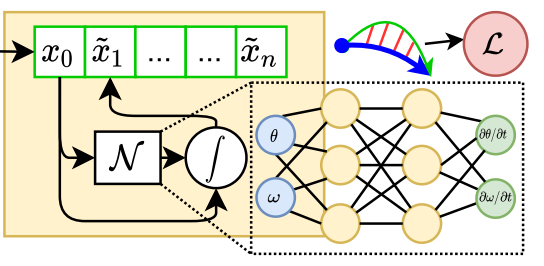

With the data generated from the MATLAB code, an implementation of the model would be as follows:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Read Time Data
time, time1= [], []
U0all, U0all1 = [], []
with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T165235/dataT.dat', 'r') as file:
    for line in file:
        time.append([float(x) for x in line.split()])

# Read the displacement data
with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T165235/dataU.dat', 'r') as file:
    for line in file:
        U0all.append([float(x) for x in line.split()])

with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T171823/dataT.dat', 'r') as file:
    for line in file:
        time1.append([float(x) for x in line.split()])

# Read the displacement data
with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T171823/dataU.dat', 'r') as file:
    for line in file:
        U0all1.append([float(x) for x in line.split()])


time = np.squeeze(np.array(time))
time1 = np.squeeze(np.array(time1))
U0all = np.array(U0all)
U0all1 = np.array(U0all1)

u_end = np.squeeze(np.reshape(U0all[32], (-1, 1)))
w_end = np.squeeze(np.reshape(U0all[33], (-1, 1)))
u_mid = np.squeeze(np.reshape(U0all[16], (-1, 1)))
w_mid = np.squeeze(np.reshape(U0all[17], (-1, 1)))

u_end1 = np.squeeze(np.reshape(U0all1[32], (-1, 1)))
w_end1 = np.squeeze(np.reshape(U0all1[33], (-1, 1)))
u_mid1= np.squeeze(np.reshape(U0all1[16], (-1, 1)))
w_mid1 = np.squeeze(np.reshape(U0all1[17], (-1, 1)))

timesteps = len(time)

def build_model():
  inputs = tf.keras.Input(shape=(timesteps, 1))
  lstm_layer = tf.keras.layers.LSTM(units=64, return_sequences=False)(inputs)
  outputs = tf.keras.layers.Dense(1)(lstm_layer)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse', optimizer='adam')
  return model

def train_model(model, X_train, y_train, epochs=2000):
  model.fit(X_train, y_train, epochs=epochs, verbose=2)

def predict_next(model, initial_displacement):
  initial_displacement = tf.reshape(initial_displacement, (1, 1))
  prediction = model.predict(initial_displacement)
  return prediction[0][0]

x_train = u_end
x_train = np.expand_dims(x_train, axis=-1)
y_train = time
y_train = np.expand_dims(y_train, axis=-1)
model = build_model()
train_model(model, x_train, y_train)

initial = u_end1[0]
pred_disp = [initial]
for i in range (len(time1)):
    prediction = predict_next(build_model(), initial)
    pred_disp.append(prediction)
    initial = prediction


plt.plot(time, u_end, c='black', label='true')
plt.plot(time, pred_disp[:-1], c='red', label='predicted', linestyle='--')
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

***Observations from the graphs obtained by the model to be shown here***

### 3.2 Neural Ordinary Differential Equations (NODEs)

NODEs, unlike the other models, construct models by combining a numerical solver with a Neural Network that then approximates derivatives of the systems. This is done by considering the ML problem itself to be a dynamical system that can be solved using a numerical solver. The numerical solver is used to continuously integrate the derivates through time.  The network architecture can be visualized as:

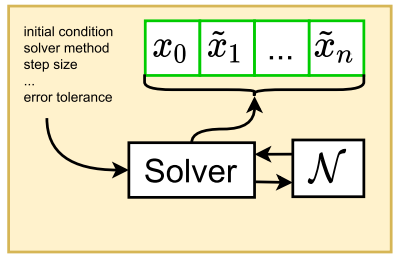

The Neural Network itself can be a Hamiltonian or Lagrangian time-steppers.
In the code snippet below, shows the implementation of the approach using NODEs on the data generated by the MATLAB code

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np


class NeuralODE(tf.keras.Model):
  def __init__(self, time_points):
    super(NeuralODE, self).__init__()

    self.time_points = time_points
    self.fc1 = layers.Dense(16, activation="relu")

  def call(self, inputs):
    y0, t = inputs

    def ode_func(y, t):

      h = tf.concat([y, t], axis=-1)
      h = self.fc1(h)
      dy_dt = h
      return dy_dt


    with tf.GradientTape() as tape:
      tape.watch(y0)
      y = tf.expand_dims(y0, axis=0)
      for t_point in self.time_points:
        y = tf.odeint(ode_func, y, [t_point], integrate_time_as_tensor=True)[1]
    dy_dt = tape.gradient(y, y0)

    return y, dy_dt
time, time1= [], []
U0all, U0all1 = [], []
with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T165235/dataT.dat', 'r') as file:
    for line in file:
        time.append([float(x) for x in line.split()])

# Read the displacement data
with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T165235/dataU.dat', 'r') as file:
    for line in file:
        U0all.append([float(x) for x in line.split()])

with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T171823/dataT.dat', 'r') as file:
    for line in file:
        time1.append([float(x) for x in line.split()])

# Read the displacement data
with open('C:/Users/awasthi/Desktop/PAML/PAMLExcercise/NLEBB_Dynamic/tr-20240409T171823/dataU.dat', 'r') as file:
    for line in file:
        U0all1.append([float(x) for x in line.split()])


time = np.squeeze(np.array(time))
time1 = np.squeeze(np.array(time1))
U0all = np.array(U0all)
U0all1 = np.array(U0all1)

u_end = np.squeeze(np.reshape(U0all[32], (-1, 1)))
w_end = np.squeeze(np.reshape(U0all[33], (-1, 1)))
u_mid = np.squeeze(np.reshape(U0all[16], (-1, 1)))
w_mid = np.squeeze(np.reshape(U0all[17], (-1, 1)))

u_end1 = np.squeeze(np.reshape(U0all1[32], (-1, 1)))
w_end1 = np.squeeze(np.reshape(U0all1[33], (-1, 1)))
u_mid1= np.squeeze(np.reshape(U0all1[16], (-1, 1)))
w_mid1 = np.squeeze(np.reshape(U0all1[17], (-1, 1)))



model = NeuralODE(time)
train_data = [
  (u_end[0], time, u_end),

]

timesteps = len(time)

optimizer = tf.keras.optimizers.Adam()

num_epochs = 100

for epoch in range(num_epochs):
  for y0, t, y_true in train_data:
    with tf.GradientTape() as tape:
      predicted_y, _ = model([y0, t])  # Forward pass
      loss = tf.reduce_mean(tf.square(predicted_y - y_true))  # MSE loss
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

preds=[]
initial=u_end1[0]
for i in range (len(time1)):
    predicted_y, _ = model([initial, time[i]])
    preds.append(predicted_y)
    initial = predicted_y

print (predicted_y)

***Observations from the graphs obtained by the NODE code here***

NODEs can be further extended using Latent NODEs, where an encoder is used to obtain a latent representation of the system's initial state by aggregating information from several observations of the systems. The system is then simulated for multiple steps to obtain the successive aggregates which are then finally mapped back to the original state space.

### 3.3 Augmented Neural Ordinary Differential Equations (ANODE)
There are often functions that NODEs cannot represent, for example, if the two trajectories of two ODEs in a state space intersect. When trained on such a state space, the learned trajectories in the vector field are highly inaccurate.

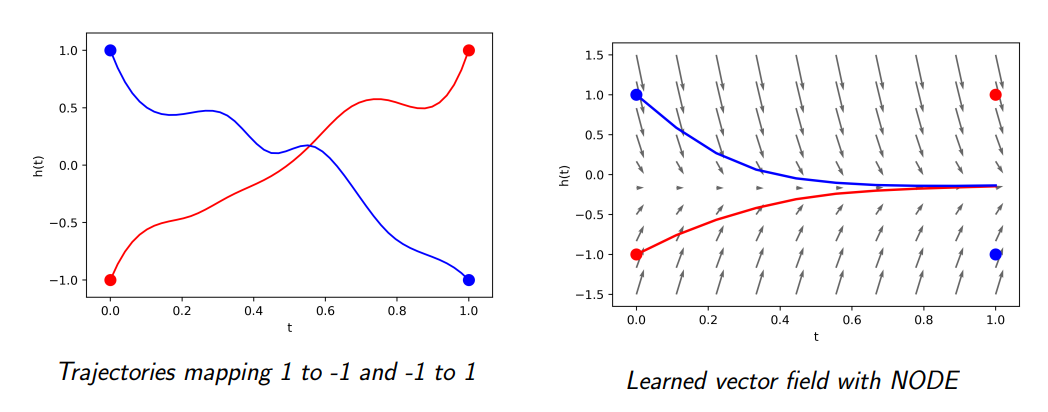

ANODEs augment additional dimensions to NODEs such that the ODE flows can lift points into the other dimensions to avoid intersecting trajectories.  As a result, they are significantly more stable, require fewer function evaluations, and are overall able to generalize better.

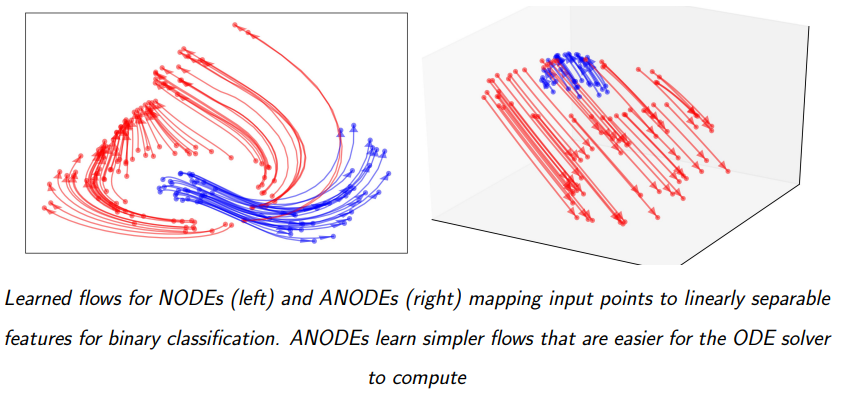